# Predicting Teacher Turnover

__Meaghan Ross__

Flatiron School Capstone

### Business Understanding

### Data Understanding

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

### Data Preparation

In [2]:
ls data/

SPR_SY1415_School_Metric_Scores_20160208.xlsx
SPR_SY1516_School_Metric_Scores_20170203.xlsx
SPR_SY1617_School_Metric_Scores_20180206.xlsx
SPR_SY1718_School_Metric_Scores_20190129.xlsx
SPR_SY1819_School_Metric_Scores_20200127.xlsx
employee_information_April2015.csv
employee_information_April2016.csv
employee_information_April2017.csv
employee_information_April2018.csv
employee_information_April2019.csv
employee_information_April2020.csv
employee_information_April2021.csv


#### Teacher Data

Load in the data from the 2018 and 2019 employee information files.

In [3]:
teacher_df_2018 = pd.read_csv('data/employee_information_April2018.csv')
teacher_df_2019 = pd.read_csv('data/employee_information_April2019.csv')

In [4]:
teacher_df_2018.head()

,LAST_NAME,FIRST_NAME,PAY_RATE_TYPE,PAY_RATE,TITLE_DESCRIPTION,HOME_ORGANIZATION,HOME_ORGANIZATION_DESCRIPTION,ORGANIZATION_LEVEL,TYPE_OF_REPRESENTATION,GENDER,RUN_DATE
0,AARON,ANDREA,SALARIED,32199,"GENERAL CLEANER, 8 HOURS",4300,"HESTON, EDWARD SCHOOL",ELEMENTARY SCHOOL,LOCAL 1201,F,4/1/2018
1,AARON,PEGGY,SALARIED,10084,"STUDENT CLIMATE STAFF,4 HOURS",6360,ROOSEVELT ELEMENTARY SCHOOL,ELEMENTARY SCHOOL,LOCAL 634,F,4/1/2018
2,ABARY,RODNEY,SALARIED,76461,SCHOOL NURSE,2370,"MCDANIEL, DELAPLAINE SCHOOL",ELEMENTARY SCHOOL,PFT-TEACHER,M,4/1/2018
3,ABATE,JO-ANN,HOURLY,39,TEACHER-EXTRA CURR/STAFF DEVEL,9EW0,NON-PUBLIC PROGRAMS,NON ADMINISTRATIVE OFFICE,PFT-TEACHER,F,4/1/2018
4,ABAYOMI-IGE,OLABIMPE,SALARIED,90051,"TEACHER,SPEC EDUCATION",5070,PARKWAY-NORTHWEST HIGH SCHOOL,HIGH SCHOOL,PFT-TEACHER,F,4/1/2018


In [5]:
teacher_df_2018.shape

(19181, 11)

In [6]:
teacher_df_2019.head()

,LAST_NAME,FIRST_NAME,PAY_RATE_TYPE,PAY_RATE,TITLE_DESCRIPTION,HOME_ORGANIZATION,HOME_ORGANIZATION_DESCRIPTION,ORGANIZATION_LEVEL,TYPE_OF_REPRESENTATION,GENDER,RUN_DATE
0,AARAS,YOUSRA,SALARIED,10383,"STUDENT CLIMATE STAFF,4 HOURS",2620,ACADEMY AT PALUMBO,HIGH SCHOOL,LOCAL 634,F,4/1/2019
1,AARON,ANDREA,SALARIED,33165,"GENERAL CLEANER, 8 HOURS",4300,"HESTON, EDWARD SCHOOL",ELEMENTARY SCHOOL,LOCAL 1201,F,4/1/2019
2,AARON,ATIA,SALARIED,12979,"STUDENT CLIMATE STAFF,5 HOURS",2050,SCIENCE LEADERSHIP ACADEMY MS,MIDDLE SCHOOL,LOCAL 634,F,4/1/2019
3,AARON,PEGGY,SALARIED,10383,"STUDENT CLIMATE STAFF,4 HOURS",7130,"WAGNER, GEN. LOUIS MIDDLE SCH.",MIDDLE SCHOOL,LOCAL 634,F,4/1/2019
4,ABARA,BERNADINE,SALARIED,7788,"STUDENT CLIMATE STAFF,3 HOURS",8310,"MOORE, J. HAMPTON SCHOOL",ELEMENTARY SCHOOL,LOCAL 634,F,4/1/2019


In [7]:
teacher_df_2019.shape

(20151, 11)

In order to find out the teacher turnover after the 2018 school year, we will merge the 2018 personnel files with the 2019 personnel files using a left join to identify all of the employees of the Philadelphia school system in 2018. The join will use the employee's first and last name as well as their school name since we want to identify teachers who remained in the same school the following year. If there are null values in 2019, then it means the employee did not return for the following school year.

In [8]:
merged_df= pd.merge(teacher_df_2018, teacher_df_2019, 
                    on=['LAST_NAME', 'FIRST_NAME', 'HOME_ORGANIZATION'], 
                    how='left', suffixes=('_2018', '_2019'))

In [9]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19279 entries, 0 to 19278
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   LAST_NAME                           19278 non-null  object 
 1   FIRST_NAME                          19279 non-null  object 
 2   PAY_RATE_TYPE_2018                  19279 non-null  object 
 3   PAY_RATE_2018                       19279 non-null  int64  
 4   TITLE_DESCRIPTION_2018              19279 non-null  object 
 5   HOME_ORGANIZATION                   19279 non-null  object 
 6   HOME_ORGANIZATION_DESCRIPTION_2018  19279 non-null  object 
 7   ORGANIZATION_LEVEL_2018             19279 non-null  object 
 8   TYPE_OF_REPRESENTATION_2018         18962 non-null  object 
 9   GENDER_2018                         19279 non-null  object 
 10  RUN_DATE_2018                       19279 non-null  object 
 11  PAY_RATE_TYPE_2019                  14258

The merged data frame includes all employes of the School District of Philadelphia. Let's look at identifying those who are labeled as teachers.

In [10]:
merged_df['TITLE_DESCRIPTION_2018'].value_counts()

TEACHER,FULL TIME                 6789
SPECIAL EDUCATION ASSISTANT       1848
TEACHER,SPEC EDUCATION            1389
GENERAL CLEANER, 8 HOURS           558
FOOD SVCS ASSISTANT                428
                                  ... 
EX DIR,INNOVATION OFFICE             1
CLERK                                1
DEPUTY CHIEF,TALENT ACQUISIT         1
DIR,FINANCIAL SERVICES               1
EX DIR PARTNERSHIP SUP & DEVEL       1
Name: TITLE_DESCRIPTION_2018, Length: 591, dtype: int64

We are going to create a new DataFrame that only includes those employees identified as `TEACHER,FULL TIME` or `TEACHER,SPEC EDUCATION` as the remaining employee types are outside of the classroom or support staff who do not need to be liscenced educators.

In [11]:
teacher_df = merged_df.loc[(merged_df['TITLE_DESCRIPTION_2018']=='TEACHER,FULL TIME')|
                           (merged_df['TITLE_DESCRIPTION_2018']=='TEACHER,SPEC EDUCATION')]


In [12]:
teacher_df.isna().sum()

LAST_NAME                                1
FIRST_NAME                               0
PAY_RATE_TYPE_2018                       0
PAY_RATE_2018                            0
TITLE_DESCRIPTION_2018                   0
HOME_ORGANIZATION                        0
HOME_ORGANIZATION_DESCRIPTION_2018       0
ORGANIZATION_LEVEL_2018                  0
TYPE_OF_REPRESENTATION_2018              0
GENDER_2018                              0
RUN_DATE_2018                            0
PAY_RATE_TYPE_2019                    1593
PAY_RATE_2019                         1593
TITLE_DESCRIPTION_2019                1593
HOME_ORGANIZATION_DESCRIPTION_2019    1593
ORGANIZATION_LEVEL_2019               1593
TYPE_OF_REPRESENTATION_2019           1593
GENDER_2019                           1593
RUN_DATE_2019                         1593
dtype: int64

Looking at the null values now, we can see there is one teacher with a null value for their last name, so we will fill it with 'None'. The additional null values are all in the columns from 2019 indicating that those are the teachers who left after the 2018 school year, and we want to keep those null values for now.

In [13]:
teacher_df.loc[:,['LAST_NAME']]=teacher_df['LAST_NAME'].fillna(value='None')

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [14]:
teacher_df.isna().sum()

LAST_NAME                                0
FIRST_NAME                               0
PAY_RATE_TYPE_2018                       0
PAY_RATE_2018                            0
TITLE_DESCRIPTION_2018                   0
HOME_ORGANIZATION                        0
HOME_ORGANIZATION_DESCRIPTION_2018       0
ORGANIZATION_LEVEL_2018                  0
TYPE_OF_REPRESENTATION_2018              0
GENDER_2018                              0
RUN_DATE_2018                            0
PAY_RATE_TYPE_2019                    1593
PAY_RATE_2019                         1593
TITLE_DESCRIPTION_2019                1593
HOME_ORGANIZATION_DESCRIPTION_2019    1593
ORGANIZATION_LEVEL_2019               1593
TYPE_OF_REPRESENTATION_2019           1593
GENDER_2019                           1593
RUN_DATE_2019                         1593
dtype: int64

#### School Data

Load in the data from the 2018 School Progress Reports from the School District of Philadelphia. The school ratings from the 2018 school year would likely influence teacher turnover and whether a teacher returns or not for the 2019 school year.

In [15]:
school_df_2018 = pd.read_excel('data/SPR_SY1718_School_Metric_Scores_20190129.xlsx', sheet_name='SPR SY2017-2018')
school_df_2018.head()

,School,SRC School ID,ULCS Code,Report,Rpt Type Long,Street Address,City,State,Zip Code,Phone Number,...,FAFSA Tier,Student Survey College & Career Score,Student Survey College & Career Pts Earn,Student Survey College & Career Pts Poss,Student Survey College & Career Pct Earn,Student Survey College & Career Tier,Teach Effect Distinguished Score,Teach Effect Instruction Score,Teacher Attendance Score,Student Survey Teaching Score
0,John Bartram High School,101,1010,HS,High School,2401 S. 67th St.,Philadelphia,PA,19142,215-400-8100,...,INTERVENE,33,0.33,1,33,WATCH,Data Not Available,Data Not Available,52,43
1,West Philadelphia High School,102,1020,HS,High School,4901 Chestnut St.,Philadelphia,PA,19139,215-400-7900,...,WATCH,0,0,1,0,INTERVENE,Data Not Available,Data Not Available,49,0
2,High School of the Future,103,1030,HS,High School,4021 Parkside Ave.,Philadelphia,PA,19104,215-400-7790,...,REINFORCE,40,0.4,1,40,WATCH,Data Not Available,Data Not Available,56,36
3,Paul Robeson High School for Human Services,105,1050,HS,High School,4125 Ludlow St.,Philadelphia,PA,19104,215-400-7780,...,MODEL,39,0.39,1,39,WATCH,Data Not Available,Data Not Available,68,53
4,William L. Sayre High School,110,1100,HS,High School,5800 Walnut St.,Philadelphia,PA,19139,215-400-7800,...,INTERVENE,0,0,1,0,INTERVENE,Data Not Available,Data Not Available,71,0


The School Progress Reports contain many features, including the way some of the features are calculated and features that are specific to a certain type of school and are not reported across all schools. For the purpose of our model, we want to include information that is reported for all schools including features regarding student achievement, school climate, and progress from prior years.

In [16]:
school_col_keep = ['School', 'ULCS Code', 'Report', 'Turnaround Model', 'Enrollment',
                   'Grades Served', 'Admissions Type', 'Overall Score', 'Overall Tier', 
                   'Ach Score', 'Ach Tier', 'Prog Score', 'Prog Tier', 'Clim Score', 
                   'Clim Tier', 'Attendance (95%+) Score', 'Attendance (95%+) Tier', 
                   'Retention Score', 'Retention Tier', 'ISS Score', 'ISS Tier', 'OSS Score',
                   'OSS Tier', 'Student Survey Climate Score', 'Student Survey Climate Tier', 
                   'Parent Survey Climate Score', 'Parent Survey Climate Tier', 
                   'Parent Survey Participation Score', 'Parent Survey Participation Tier', 
                   'Teacher Attendance Score','Student Survey Teaching Score']
school_df_2018=school_df_2018[school_col_keep]

In [17]:
school_df_2018.head()

,School,ULCS Code,Report,Turnaround Model,Enrollment,Grades Served,Admissions Type,Overall Score,Overall Tier,Ach Score,...,OSS Score,OSS Tier,Student Survey Climate Score,Student Survey Climate Tier,Parent Survey Climate Score,Parent Survey Climate Tier,Parent Survey Participation Score,Parent Survey Participation Tier,Teacher Attendance Score,Student Survey Teaching Score
0,John Bartram High School,1010,HS,NaN,561,'9-12',Neighborhood,13,INTERVENE,0,...,82,WATCH,52,REINFORCE,0,INTERVENE,2,INTERVENE,52,43
1,West Philadelphia High School,1020,HS,Turnaround,478,'9-12',Neighborhood,8,INTERVENE,0,...,76,INTERVENE,0,INTERVENE,0,INTERVENE,8,INTERVENE,49,0
2,High School of the Future,1030,HS,NaN,488,'9-12',Citywide,25,WATCH,0,...,87,REINFORCE,55,REINFORCE,0,INTERVENE,2,INTERVENE,56,36
3,Paul Robeson High School for Human Services,1050,HS,NaN,299,'9-12',Citywide,44,WATCH,3,...,95,MODEL,64,REINFORCE,82,MODEL,13,INTERVENE,68,53
4,William L. Sayre High School,1100,HS,NaN,425,'9-12',Neighborhood,8,INTERVENE,0,...,82,WATCH,0,INTERVENE,0,INTERVENE,8,INTERVENE,71,0


When checking for null values, the `Turnaround Model` has null values meaning the school was not identified to participate in a turnaround model for the 2017-2018 school year. The null values will be filled with 'None'.

In [18]:
school_df_2018.isna().sum()

School                                 0
ULCS Code                              0
Report                                 0
Turnaround Model                     272
Enrollment                             0
Grades Served                          0
Admissions Type                        0
Overall Score                          0
Overall Tier                           0
Ach Score                              0
Ach Tier                               0
Prog Score                             0
Prog Tier                              0
Clim Score                             0
Clim Tier                              0
Attendance (95%+) Score                0
Attendance (95%+) Tier                 0
Retention Score                        0
Retention Tier                         0
ISS Score                              0
ISS Tier                               0
OSS Score                              0
OSS Tier                               0
Student Survey Climate Score           0
Student Survey C

In [19]:
school_df_2018.loc[:,['Turnaround Model']]=school_df_2018['Turnaround Model'].fillna(value='None')

In [20]:
school_df_2018.isna().sum()

School                               0
ULCS Code                            0
Report                               0
Turnaround Model                     0
Enrollment                           0
Grades Served                        0
Admissions Type                      0
Overall Score                        0
Overall Tier                         0
Ach Score                            0
Ach Tier                             0
Prog Score                           0
Prog Tier                            0
Clim Score                           0
Clim Tier                            0
Attendance (95%+) Score              0
Attendance (95%+) Tier               0
Retention Score                      0
Retention Tier                       0
ISS Score                            0
ISS Tier                             0
OSS Score                            0
OSS Tier                             0
Student Survey Climate Score         0
Student Survey Climate Tier          0
Parent Survey Climate Sco

### Merging Teacher Data with School Data

In order to merge the individual teacher data with the school progress report data, we will need to merge on the school code as the school name is not written the same between files. The school code is consistent, however, in the teacher data it is stored as an object when it is numerical in the school data.

We will turn the `HOME_ORGANIZATION` code into a numeric and those that are numerical will be coerced to a null value. The staff with the non-numeric codes are assigned to locations that are not actual school buildings such as code `9KT0` represents the Office of High School Support.

Then, we will drop the null values from the `HOME ORGANIZATION`.

In [21]:
teacher_df.loc[:,['HOME_ORGANIZATION']] = pd.to_numeric(teacher_df['HOME_ORGANIZATION'], 
                                                        errors='coerce')

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [22]:
teacher_df.dropna(subset = ['HOME_ORGANIZATION'], inplace=True)

<ipython-input-22-56446d0974df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teacher_df.dropna(subset = ['HOME_ORGANIZATION'], inplace=True)


In [23]:
teacher_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8085 entries, 4 to 19277
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   LAST_NAME                           8085 non-null   object 
 1   FIRST_NAME                          8085 non-null   object 
 2   PAY_RATE_TYPE_2018                  8085 non-null   object 
 3   PAY_RATE_2018                       8085 non-null   int64  
 4   TITLE_DESCRIPTION_2018              8085 non-null   object 
 5   HOME_ORGANIZATION                   8085 non-null   float64
 6   HOME_ORGANIZATION_DESCRIPTION_2018  8085 non-null   object 
 7   ORGANIZATION_LEVEL_2018             8085 non-null   object 
 8   TYPE_OF_REPRESENTATION_2018         8085 non-null   object 
 9   GENDER_2018                         8085 non-null   object 
 10  RUN_DATE_2018                       8085 non-null   object 
 11  PAY_RATE_TYPE_2019                  6521 n

Now we can merge the teacher data with the school data using what is referred to as `HOME_ORGANIZATION` in the teacher data and the `ULCS Code` for the school data.

In [25]:
full_df= pd.merge(teacher_df, school_df_2018, 
                  left_on='HOME_ORGANIZATION', right_on='ULCS Code',
                  how='left')

In [26]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8252 entries, 0 to 8251
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   LAST_NAME                           8252 non-null   object 
 1   FIRST_NAME                          8252 non-null   object 
 2   PAY_RATE_TYPE_2018                  8252 non-null   object 
 3   PAY_RATE_2018                       8252 non-null   int64  
 4   TITLE_DESCRIPTION_2018              8252 non-null   object 
 5   HOME_ORGANIZATION                   8252 non-null   float64
 6   HOME_ORGANIZATION_DESCRIPTION_2018  8252 non-null   object 
 7   ORGANIZATION_LEVEL_2018             8252 non-null   object 
 8   TYPE_OF_REPRESENTATION_2018         8252 non-null   object 
 9   GENDER_2018                         8252 non-null   object 
 10  RUN_DATE_2018                       8252 non-null   object 
 11  PAY_RATE_TYPE_2019                  6663 no

In [27]:
full_df[full_df.filter(like='School').isnull().any(1)]

,LAST_NAME,FIRST_NAME,PAY_RATE_TYPE_2018,PAY_RATE_2018,TITLE_DESCRIPTION_2018,HOME_ORGANIZATION,HOME_ORGANIZATION_DESCRIPTION_2018,ORGANIZATION_LEVEL_2018,TYPE_OF_REPRESENTATION_2018,GENDER_2018,...,OSS Score,OSS Tier,Student Survey Climate Score,Student Survey Climate Tier,Parent Survey Climate Score,Parent Survey Climate Tier,Parent Survey Participation Score,Parent Survey Participation Tier,Teacher Attendance Score,Student Survey Teaching Score
14,ABRAHAM-CUFF,NAFHRAH,SALARIED,48527,"TEACHER,SPEC EDUCATION",6400.0,WIDENER MEMORIAL SCHOOL,ELEMENTARY SCHOOL,PFT-TEACHER,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,ABT,DEBBIE,SALARIED,78376,"TEACHER,FULL TIME",6392.0,STEEL SCHOOL HEAD START,EARLY CHILDHOOD,PFT- PRE K,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,ALLEN,HEATHER,SALARIED,52196,"TEACHER,FULL TIME",6202.0,"DAY, ANNA B. HEAD START",EARLY CHILDHOOD,PFT- PRE K,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,ALLEN,MAYA,SALARIED,45359,"TEACHER,FULL TIME",6341.0,PENNELL HEAD START,EARLY CHILDHOOD,PFT-TEACHER,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,ALLMAN,ELIZABETH,SALARIED,59532,"TEACHER,FULL TIME",4399.0,WRIGHT HEAD START,EARLY CHILDHOOD,PFT- PRE K,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8167,YORKONIS,TRACY,SALARIED,67789,"TEACHER,FULL TIME",1475.0,HAVERFORD CTR BRIGHT FUTURES,EARLY CHILDHOOD,PFT- PRE K,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8185,YU,JUYEON,SALARIED,90051,"TEACHER,FULL TIME",6400.0,WIDENER MEMORIAL SCHOOL,ELEMENTARY SCHOOL,PFT-TEACHER,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8197,ZAJDEL,HEATHER,SALARIED,90051,"TEACHER,FULL TIME",8460.0,PHILA LEARNING ACADEMY-SOUTH,TRANSITION / OVERAGE SCHOOL,PFT-TEACHER,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8213,ZELNER,KATHLEEN,SALARIED,69623,"TEACHER,FULL TIME",8272.0,HOLME HEAD START,EARLY CHILDHOOD,PFT- PRE K,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


After the merge, we can see that the teachers with no school listed are those from primarily Pre-K or Transition/Overage Schools where we don't have School Progress Report data for those schools. We will drop those ~250 rows to focus on teachers in Philadelphia schools that participated in the 2017-2018 School Progress Report.

In [28]:
full_df.dropna(subset = ['School'], inplace=True)

In [29]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7984 entries, 0 to 8251
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   LAST_NAME                           7984 non-null   object 
 1   FIRST_NAME                          7984 non-null   object 
 2   PAY_RATE_TYPE_2018                  7984 non-null   object 
 3   PAY_RATE_2018                       7984 non-null   int64  
 4   TITLE_DESCRIPTION_2018              7984 non-null   object 
 5   HOME_ORGANIZATION                   7984 non-null   float64
 6   HOME_ORGANIZATION_DESCRIPTION_2018  7984 non-null   object 
 7   ORGANIZATION_LEVEL_2018             7984 non-null   object 
 8   TYPE_OF_REPRESENTATION_2018         7984 non-null   object 
 9   GENDER_2018                         7984 non-null   object 
 10  RUN_DATE_2018                       7984 non-null   object 
 11  PAY_RATE_TYPE_2019                  6450 no

We want to only keep teachers who had a salary in 2018, so we filter out the 57 teachers listed as having a salary equal to 0.

In [30]:
full_df = full_df[full_df['PAY_RATE_2018']>0]

In [31]:
full_df.shape

(7927, 50)

We also want to create a dummy column that indicates whether a teacher is new to teaching or not using their salary information. New to teaching will be those teachers who are qualified for the Teacher Induction program:
>"Our Induction program provides one year of support that prioritizes skill development, personal reflection, and professional networking. Our model provides teachers with general pedagogical strategies that are designed for teachers in years 0-3." from https://www.philasd.org/teachingandlearning/professional-development/induction/

That means we will use cutoffs up to Step 3 from the Philadelphia Federation of Teachers' [Salary Schedule](https://jobs.philasd.org/wp-content/uploads/sites/47/2018/08/PFT-Salary-Schedules.pdf) from 2018 to indicate new to teaching. 


In [38]:
full_df['NEW_TEACHER']=0

In [39]:
full_df.head()

,LAST_NAME,FIRST_NAME,PAY_RATE_TYPE_2018,PAY_RATE_2018,TITLE_DESCRIPTION_2018,HOME_ORGANIZATION,HOME_ORGANIZATION_DESCRIPTION_2018,ORGANIZATION_LEVEL_2018,TYPE_OF_REPRESENTATION_2018,GENDER_2018,...,OSS Tier,Student Survey Climate Score,Student Survey Climate Tier,Parent Survey Climate Score,Parent Survey Climate Tier,Parent Survey Participation Score,Parent Survey Participation Tier,Teacher Attendance Score,Student Survey Teaching Score,NEW_TEACHER
0,ABAYOMI-IGE,OLABIMPE,SALARIED,90051,"TEACHER,SPEC EDUCATION",5070.0,PARKWAY-NORTHWEST HIGH SCHOOL,HIGH SCHOOL,PFT-TEACHER,F,...,REINFORCE,48,WATCH,73.0,REINFORCE,18.0,INTERVENE,67,33,0
1,ABBOTT,JOYCE,SALARIED,76461,"TEACHER,FULL TIME",1290.0,"HAMILTON, ANDREW SCHOOL",ELEMENTARY SCHOOL,PFT-TEACHER,F,...,REINFORCE,0,INTERVENE,0.0,INTERVENE,1.0,INTERVENE,46,0,0
2,ABDUL-LATEEF,VILLIA,SALARIED,56531,"TEACHER,FULL TIME",1010.0,"BARTRAM, JOHN HIGH SCHOOL",HIGH SCHOOL,PFT-TEACHER,F,...,WATCH,52,REINFORCE,0.0,INTERVENE,2.0,INTERVENE,52,43,0
3,ABDULALEEM,MUHAMMAD,SALARIED,70564,"TEACHER,FULL TIME",6090.0,RANDOLPH TECHNICAL HIGH SCHOOL,CAREER AND TECHNICAL HIGH SCHL,PFT-TEACHER,M,...,REINFORCE,56,REINFORCE,0.0,INTERVENE,2.0,INTERVENE,64,36,0
4,ABDULLAH,AARON,SALARIED,46694,"TEACHER,FULL TIME",6360.0,ROOSEVELT ELEMENTARY SCHOOL,ELEMENTARY SCHOOL,PFT-TEACHER,M,...,INTERVENE,47,WATCH,63.0,REINFORCE,10.0,INTERVENE,58,51,0


In [47]:
full_df['TYPE_OF_REPRESENTATION_2018'].value_counts()

PFT-TEACHER    7922
PFT- PRE K        5
Name: TYPE_OF_REPRESENTATION_2018, dtype: int64

In [40]:
conditions = [
    (full_df['PAY_RATE_2018'] <= 53281)&(full_df['TITLE_DESCRIPTION_2018'] == 'TEACHER,FULL TIME'),
    (full_df['PAY_RATE_2018'] <= 54534)&(full_df['TITLE_DESCRIPTION_2018'] == 'TEACHER,SPEC EDUCATION')
    ]
values = [1, 1]
full_df['NEW_TEACHER'] = np.select(conditions, values)

In [42]:
full_df['NEW_TEACHER'].value_counts(normalize=True)

0    0.828561
1    0.171439
Name: NEW_TEACHER, dtype: float64

We will establish a `TURNOVER` column that will act as the target column for modeling purposes. To do this, if a record has non-null values from the 2019 dataset, then they will be marked as 0 indicating they were retained in their 2018 school. However, if a record has a null value in the 2019 dataset, they will be marked with a 1 indicating they turned over from their 2018 school.

In [43]:
full_df['TURNOVER']=np.where(full_df['PAY_RATE_2019'].isnull(), 1,0)

In [44]:
full_df['TURNOVER'].value_counts(normalize=True)

0    0.810647
1    0.189353
Name: TURNOVER, dtype: float64

From this, we can see that nearly 20% of the public school teachers left their schools after the 2018 school year. This does indicate that there is a class imbalance at play that will need to be accounted for when modeling.

We still need to clean up some of the data before modeling. We can drop columns that will not be helpful for modeling, such as the teacher data from 2019 since it contains null values from those teachers that left their school.

In [45]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7927 entries, 0 to 8251
Data columns (total 52 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   LAST_NAME                           7927 non-null   object 
 1   FIRST_NAME                          7927 non-null   object 
 2   PAY_RATE_TYPE_2018                  7927 non-null   object 
 3   PAY_RATE_2018                       7927 non-null   int64  
 4   TITLE_DESCRIPTION_2018              7927 non-null   object 
 5   HOME_ORGANIZATION                   7927 non-null   float64
 6   HOME_ORGANIZATION_DESCRIPTION_2018  7927 non-null   object 
 7   ORGANIZATION_LEVEL_2018             7927 non-null   object 
 8   TYPE_OF_REPRESENTATION_2018         7927 non-null   object 
 9   GENDER_2018                         7927 non-null   object 
 10  RUN_DATE_2018                       7927 non-null   object 
 11  PAY_RATE_TYPE_2019                  6426 no

In [50]:
cols_to_drop = ['PAY_RATE_TYPE_2019', 'PAY_RATE_2019','TITLE_DESCRIPTION_2019', 
                'HOME_ORGANIZATION_DESCRIPTION_2019', 'ORGANIZATION_LEVEL_2019',
                'TYPE_OF_REPRESENTATION_2019','GENDER_2019','RUN_DATE_2019', 'RUN_DATE_2018',
                'HOME_ORGANIZATION_DESCRIPTION_2018', 'PAY_RATE_TYPE_2018', 'TYPE_OF_REPRESENTATION_2018',
                'ULCS Code', 'Report']

In [51]:
full_df.drop(cols_to_drop, axis=1, inplace=True)

In [52]:
full_df.head()

,LAST_NAME,FIRST_NAME,PAY_RATE_2018,TITLE_DESCRIPTION_2018,HOME_ORGANIZATION,ORGANIZATION_LEVEL_2018,GENDER_2018,School,Turnaround Model,Enrollment,...,Student Survey Climate Score,Student Survey Climate Tier,Parent Survey Climate Score,Parent Survey Climate Tier,Parent Survey Participation Score,Parent Survey Participation Tier,Teacher Attendance Score,Student Survey Teaching Score,NEW_TEACHER,TURNOVER
0,ABAYOMI-IGE,OLABIMPE,90051,"TEACHER,SPEC EDUCATION",5070.0,HIGH SCHOOL,F,Parkway Northwest High School,None,260.0,...,48,WATCH,73.0,REINFORCE,18.0,INTERVENE,67,33,0,0
1,ABBOTT,JOYCE,76461,"TEACHER,FULL TIME",1290.0,ELEMENTARY SCHOOL,F,Andrew Hamilton School,None,532.0,...,0,INTERVENE,0.0,INTERVENE,1.0,INTERVENE,46,0,0,0
2,ABDUL-LATEEF,VILLIA,56531,"TEACHER,FULL TIME",1010.0,HIGH SCHOOL,F,John Bartram High School,None,561.0,...,52,REINFORCE,0.0,INTERVENE,2.0,INTERVENE,52,43,0,1
3,ABDULALEEM,MUHAMMAD,70564,"TEACHER,FULL TIME",6090.0,CAREER AND TECHNICAL HIGH SCHL,M,A. Philip Randolph Career and Technical High S...,None,493.0,...,56,REINFORCE,0.0,INTERVENE,2.0,INTERVENE,64,36,0,0
4,ABDULLAH,AARON,46694,"TEACHER,FULL TIME",6360.0,ELEMENTARY SCHOOL,M,Theodore Roosevelt School,Turnaround,525.0,...,47,WATCH,63.0,REINFORCE,10.0,INTERVENE,58,51,1,0


### EDA

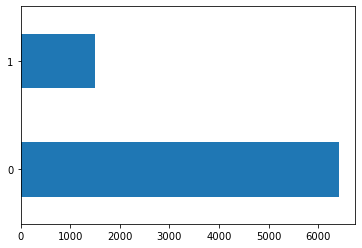

In [95]:
full_df['TURNOVER'].value_counts().plot.barh();

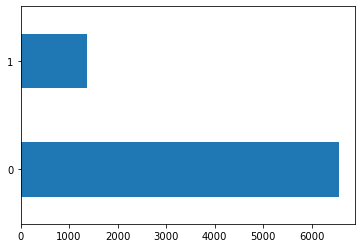

In [97]:
full_df['NEW_TEACHER'].value_counts().plot.barh();

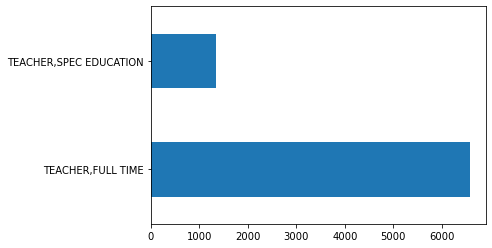

In [98]:
full_df['TITLE_DESCRIPTION_2018'].value_counts().plot.barh();

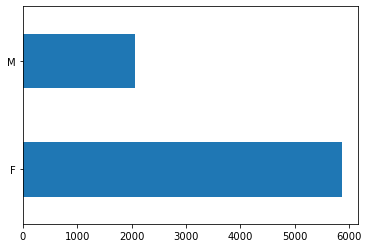

In [96]:
full_df['GENDER_2018'].value_counts().plot.barh();

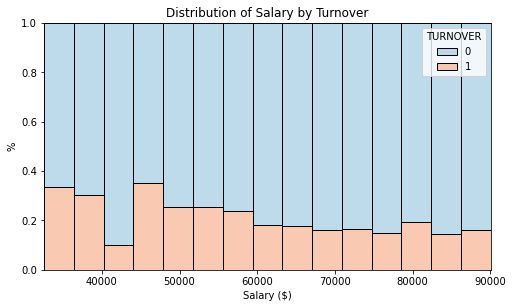

In [102]:
f = plt.figure(figsize=(8,10))
ax = f.add_subplot(2,1,1)

sns.histplot(data=full_df, ax=ax, stat='probability', multiple="fill",
             x="PAY_RATE_2018", palette = 'RdBu_r',
             hue="TURNOVER", element="bars", 
             legend=True, bins=15)
ax.set_title("Distribution of Salary by Turnover")
ax.set_xlabel("Salary ($)")
ax.set_ylabel("%");

In [100]:
full_df.corr()

,PAY_RATE_2018,HOME_ORGANIZATION,Enrollment,Clim Score,Attendance (95%+) Score,Retention Score,ISS Score,OSS Score,Parent Survey Climate Score,Parent Survey Participation Score,NEW_TEACHER,TURNOVER
PAY_RATE_2018,1.000000,0.038187,0.084483,0.124878,0.101647,0.100311,0.023937,0.094068,0.030273,-0.017216,-0.716830,-0.128383
HOME_ORGANIZATION,0.038187,1.000000,0.420716,0.161885,0.042418,0.180387,-0.048261,0.164868,-0.046431,-0.055446,-0.021044,-0.040983
Enrollment,0.084483,0.420716,1.000000,0.154257,0.089632,0.188510,-0.193487,0.054606,-0.158786,-0.197453,-0.066778,-0.074059
Clim Score,0.124878,0.161885,0.154257,1.000000,0.884434,0.889190,0.123755,0.685835,0.248483,0.192925,-0.112942,-0.147260
Attendance (95%+) Score,0.101647,0.042418,0.089632,0.884434,1.000000,0.755330,0.120543,0.644979,0.203678,0.119316,-0.094704,-0.111212
Retention Score,0.100311,0.180387,0.188510,0.889190,0.755330,1.000000,0.034136,0.583733,0.149625,0.124893,-0.094468,-0.146313
ISS Score,0.023937,-0.048261,-0.193487,0.123755,0.120543,0.034136,1.000000,0.211967,0.046071,0.056472,-0.016847,0.022632
OSS Score,0.094068,0.164868,0.054606,0.685835,0.644979,0.583733,0.211967,1.000000,0.319913,0.247719,-0.105428,-0.103168
Parent Survey Climate Score,0.030273,-0.046431,-0.158786,0.248483,0.203678,0.149625,0.046071,0.319913,1.000000,0.642356,-0.007046,-0.029399
Parent Survey Participation Score,-0.017216,-0.055446,-0.197453,0.192925,0.119316,0.124893,0.056472,0.247719,0.642356,1.000000,0.022961,-0.023279


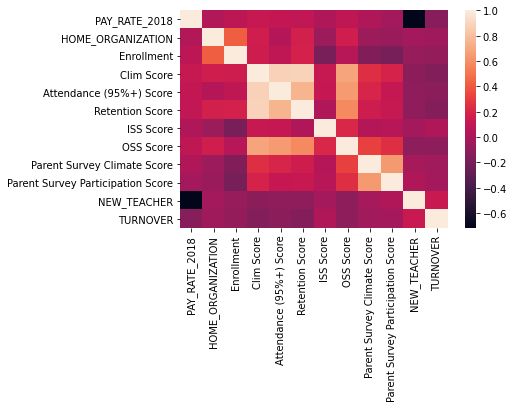

In [99]:
sns.heatmap(full_df.corr());

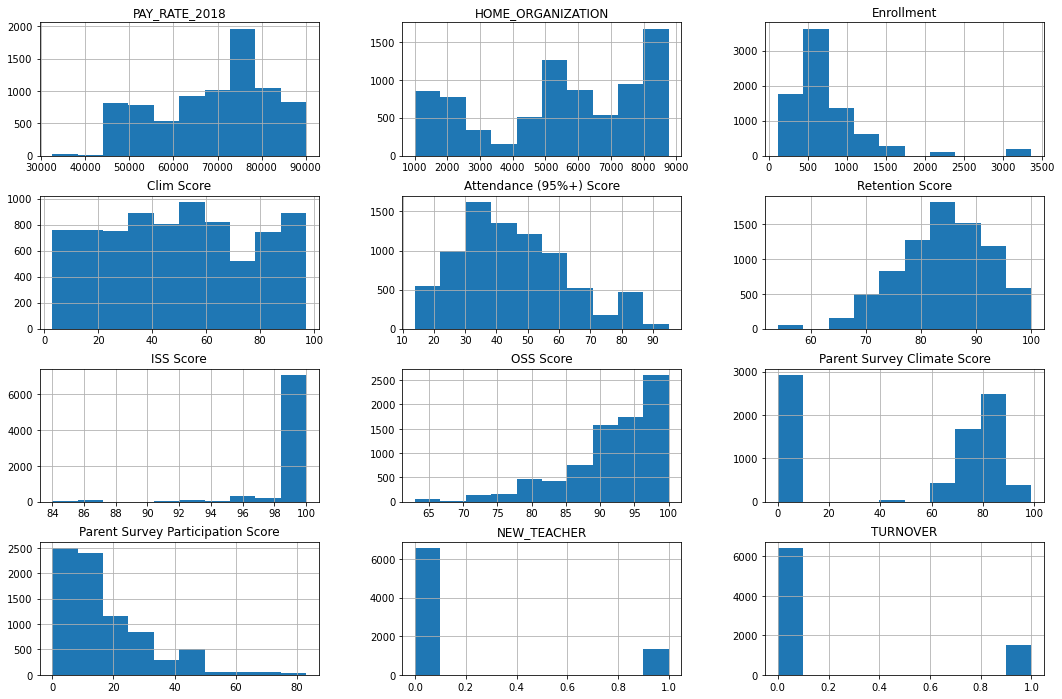

In [101]:
full_df.hist(figsize=(18, 12));


### Modeling

### Evaluation